In [ ]:
!pip install nest_asyncio xmltodict openai==0.28.0 langchain==0.0.281 tiktoken faiss-cpu tiktoken==0.4.0 html2text

In [3]:
# fixes a bug with asyncio and jupyter
import nest_asyncio
nest_asyncio.apply()
import xmltodict
from langchain.document_loaders.sitemap import SitemapLoader
import requests
from langchain.vectorstores import FAISS
from langchain.embeddings import OpenAIEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
import tiktoken
import matplotlib.pyplot as plt
import getpass
import os
import openai
from langchain.vectorstores import FAISS
import re
#second task
from langchain.document_loaders import AsyncHtmlLoader
from langchain.document_transformers import Html2TextTransformer
from langchain.chat_models import ChatOpenAI
from langchain.chains import create_extraction_chain

In [4]:
# Указываем конкретные странички для парсинга
urls = ["https://digital.wildberries.ru/info/payments",
        "https://digital.wildberries.ru/info/agreement",
        "https://digital.wildberries.ru/info/faq",
        "https://digital.wildberries.ru/info/oferta",
        "https://digital.wildberries.ru/info/personal_data",
        "https://digital.wildberries.ru/info/privacy_policy",
        "https://digital.wildberries.ru/guide",
        "https://digital.wildberries.ru/info/contacts"]
loader = AsyncHtmlLoader(urls)
docs = loader.load()

Fetching pages:   0%|          | 0/8 [00:00<?, ?it/s]

Fetching pages: 100%|##########| 8/8 [00:01<00:00,  7.95it/s]


In [5]:
# трансформируем их в текст
html2text = Html2TextTransformer()
docs_transformed = html2text.transform_documents(docs)
# выводим первые 500 символов результата
docs_transformed[0].page_content[0:500]

'####\n\nКаталог\n\nВойти\n\nУведомления\n\nПокупки\n\nКорзина\n\nЭлектронные книги\n\nАудиокниги\n\nКлючи и сертификаты\n\nФильмы и видео\n\nМузыка и аудио\n\nЦифровые товары\n\nЖурналы\n\nУслуги\n\nБизнес-консультант\n\nWB-stream\n\n###\n\nВсе предложения\n\nПопулярные\n\nАктуальные\n\nСкидки и акции\n\n  1. Главная\n  2. Способы оплаты\n\n# Способы оплаты\n\n### Банковская карта\n\nОплата банковской картой, через Интернет, возможна через системы электронных\nплатежей.\n\nНомер карты (PAN) должен иметь не менее 15 и не более 19 символов.\n\nМы при'

In [6]:
# Получение ключа API от пользователя и установка его как переменной окружения
openai_key = getpass.getpass("OpenAI API Key:")
os.environ["OPENAI_API_KEY"] = openai_key
openai.api_key = openai_key

In [17]:
# инициализируем модель
llm = ChatOpenAI(temperature=0, model="gpt-3.5-turbo-16k")

In [33]:
#  применяем create_extraction_chain для извлечения названия статьи
schema = {
    "properties": {
        "article_title": {"type": "string"}
    },
    "required": ["article_title"]
}

def extract(content: str, schema: dict):
    return create_extraction_chain(schema=schema, llm=llm).run(content)

In [36]:
# Применяем функцию extract ко всем документам
extracted_data_all = []

for doc in docs_transformed:
    content = doc.page_content

    # Применяем функцию extract
    extracted_content = extract(content=content, schema=schema)

    # Добавляем извлеченные данные в список (если нужно)
    extracted_data_all.append(extracted_content)

Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised APIConnectionError: Error communicating with OpenAI: ('Connection aborted.', ConnectionResetError(10054, 'Удаленный хост принудительно разорвал существующее подключение', None, 10054, None)).


In [37]:
extracted_data_all

[[{'article_title': 'Способы оплаты'}],
 [{'article_title': 'Правила пользования торговой площадкой "Wildberries"'}],
 [{'article_title': 'Что такое цифровой товар?'},
  {'article_title': 'Как я получу цифровой товар?'},
  {'article_title': 'В каком формате доступен контент на сайте Digital.Wildberries.ru?'},
  {'article_title': 'Какие есть способы оплаты?'},
  {'article_title': 'Когда мне откроется доступ на приобретенный товар/услугу?'},
  {'article_title': 'Что делать, если не открылся доступ на товар и не пришло письмо?'},
  {'article_title': 'Где можно посмотреть все мои цифровые покупки сделанные на сайте Digital.Wildberries.ru?'},
  {'article_title': 'Я приобрел(а) подписку на онлайн-кинотеатр на определенный период, будет ли автопродление?'},
  {'article_title': 'Могу ли я изменить почту для получения письма от Digital.Wildberries.ru?'},
  {'article_title': 'Могу ли я вернуть цифровой товар?'},
  {'article_title': 'Как стать продавцом цифрового контента?'},
  {'article_title': 

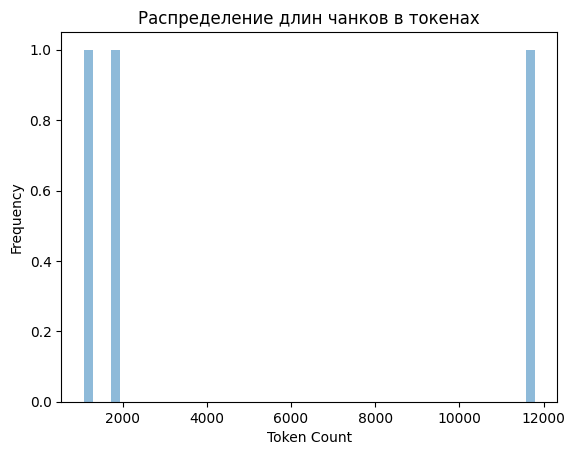

In [38]:
def num_tokens_from_string(string: str, encoding_name: str) -> int:
      """Возвращает количество токенов в строке"""
      encoding = tiktoken.get_encoding(encoding_name)
      num_tokens = len(encoding.encode(string))
      return num_tokens
# Подсчет токенов для каждого фрагмента и построение графика
fragment_token_counts = [num_tokens_from_string(fragment.page_content, "cl100k_base") for fragment in docs_transformed]
plt.hist(fragment_token_counts, bins=50, alpha=0.5, label='Fragments')
plt.title('Распределение длин чанков в токенах')
plt.xlabel('Token Count')
plt.ylabel('Frequency')
plt.show()

In [39]:
def split_into_chunks(content: str, title: str, max_tokens: int = 1000, encoding_name: str = "cl100k_base") -> list:
    chunks = []
    start_index = 0

    while start_index < len(content):
        # Пытаемся взять максимум токенов
        end_index = start_index + max_tokens
        if end_index > len(content):
            end_index = len(content)

        # Находим последний символ \n\n или \n, чтобы разделить по нему
        split_index_nn = content.rfind("\n\n", start_index, end_index)
        split_index_n = content.rfind("\n", start_index, end_index)

        # Выбираем максимальный индекс из двух возможных вариантов разделения
        split_index = max(split_index_nn, split_index_n)

        # Если не можем найти \n\n или \n, используем end_index
        if split_index == -1:
            split_index = end_index

        chunk = content[start_index:split_index]

        # Проверяем, не превышает ли количество токенов 1000
        while num_tokens_from_string(f"# {title}\n\n{chunk}", encoding_name) > max_tokens and split_index > start_index:
            split_index_nn = content.rfind("\n\n", start_index, split_index-1)
            split_index_n = content.rfind("\n", start_index, split_index-1)

            # Аналогично выбираем максимальный индекс для нового разделения
            split_index = max(split_index_nn, split_index_n)
            chunk = content[start_index:split_index]

        # Добавляем чанк в список с добавлением заголовка и устанавливаем новый start_index
        chunks.append(f"# {title}\n\n{chunk}".strip())
        start_index = split_index + 1

    return chunks

# Применяем функцию для разбивки на чанки
chunks_all = []

for doc, extracted in zip(docs_transformed, extracted_data_all):
    title = extracted[0].get("article_title", "") if extracted else ""
    chunks = split_into_chunks(doc.page_content, title)
    chunks_all.extend(chunks)


In [40]:
# получилось чанков
len(chunks_all)

39

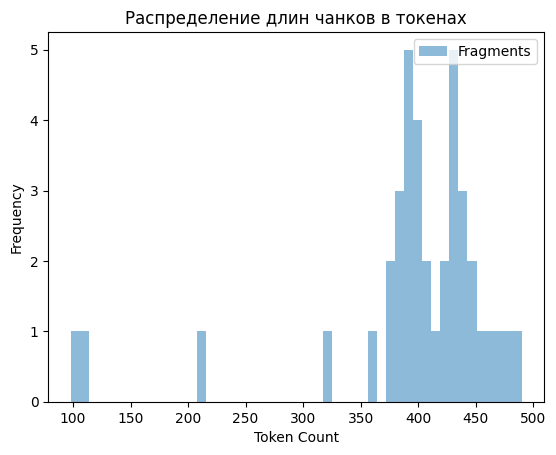

In [41]:
# посмотрим на распределение длин чанков после разделения на более мелкие чанки
def num_tokens_from_strings(strings: list[str], encoding_name: str) -> list[int]:
    """Возвращает количество токенов в списке строк"""
    encoding = tiktoken.get_encoding(encoding_name)

    # Подсчет токенов для каждой строки и создание списка с количеством токенов
    num_tokens_per_string = [len(encoding.encode(string)) for string in strings]
    return num_tokens_per_string

# Если chunks_all - это просто список строк, используем его напрямую
fragment_token_counts = num_tokens_from_strings(chunks_all, "cl100k_base")

# Визуализируем результат
plt.hist(fragment_token_counts, bins=50, alpha=0.5, label='Fragments')
plt.title('Распределение длин чанков в токенах')
plt.xlabel('Token Count')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.show()

In [42]:
# Инициализирум модель эмбеддингов
embeddings = OpenAIEmbeddings()

# Создадим индексную базу из разделенных фрагментов текста
db_2 = FAISS.from_texts(chunks_all, embeddings)

In [45]:
system= "Ответь на вопрос пользователя коротко, опираясь точно на документ с информацией для ответа клиенту. Не придумывай ничего от себя. Не ссылайся на сами отрывки документ с информацией для ответа, клиент о них ничего не должен знать."

In [46]:
def answer_index(system, topic, search_index, temp=0, verbose=0) -> str:
    """
    Функция возвращает ответ модели на основе заданной темы.
    """
    # находим наиболее релевантные вопросу пользователя чанки:
    docs = search_index.similarity_search(topic, k=6)
    message_content = re.sub(r'\n{2}', ' ', '\n '.join([f'\nОтрывок документа №{i+1}\n=====================' + doc.page_content + '\n' for i, doc in enumerate(docs)]))

    # если параметр verbose=1, то выводим релевантные чанки
    if verbose:
        print('message_content :\n', message_content)

    messages = [
        {"role": "system", "content": system},
        {"role": "user", "content": f"Ответь на вопрос пользователя, но не упоминай данные тебе документы с информацией в ответе. Документ с информацией для ответа пользователю: {message_content}\n\nВопрос пользователя: \n{topic}"}
    ]

    completion = openai.ChatCompletion.create(
        model="gpt-3.5-turbo",
        messages=messages,
        temperature=temp
    )

    return completion.choices[0].message.content

In [47]:
topic = "Какой способ оплаты?"
ans=answer_index(system, topic, db_2, temp=0, verbose=0)
ans

'На сайте Digital.Wildberries.ru доступны два способа оплаты: через СБП (Систему быстрых платежей) или банковской картой.'

In [48]:
topic = "Кто такой автор?"
ans=answer_index(system, topic, db_2, temp=0, verbose=0)
ans

'Автор - это лицо или организация, которые создают цифровой контент, такой как электронные книги, музыка, видео, игры и другие цифровые товары.'

In [49]:
topic = "Как можно отменить заказ?"
ans=answer_index(system, topic, db_2, temp=0, verbose=0)
ans

'Вы можете отменить заказ на торговой площадке "Wildberries" в течение 10 минут с момента оформления, если выбрали безналичный способ оплаты и не произвели оплату.'